# Kaggle Facial Keypoints Detection

EN:http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

JP:https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils import plot_model
from keras.layers import Conv2D
from keras.backend import tensorflow_backend as KTF
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def load(test=False, cols=None):
    """testがTrueの場合はFTESTからデータを読み込み、Falseの場合はFTRAINから読み込みます。
    colsにリストが渡された場合にはそのカラムに関するデータのみ返します。
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) # pandasのdataframeを使用

    # スペースで句切られているピクセル値をnumpy arrayに変換
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # カラムに関連するデータのみを抽出
        df = df[list(cols) + ['Image']]

    print(df.count())  # カラム毎に値が存在する行数を出力
    df = df.dropna()  # データが欠けている行は捨てる

    X = np.vstack(df['Image'].values) / 255.  # 0から1の値に変換
    X = X.astype(np.float32)

    if not test:  # ラベルが存在するのはFTRAINのみ
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # -1から1の値に変換
        X, y = shuffle(X, y, random_state=42)  # データをシャッフル
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [4]:
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

In [5]:
def Xflip():
    X, y = load2d()
    X_flipped = X[:, :, ::-1, :]
    return X_flipped

In [6]:
#old_session = KTF.get_session()

In [7]:
def net1():
    model = Sequential()
    
    model.add(Dense(100, input_dim=9216))
    model.add(Activation('relu'))
    model.add(Dense(30))
    
    return model

In [8]:
def net2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dense(30))
    
    return model

In [9]:
def net3():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dense(30))
    
    return model

In [10]:
def net4():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(30))
    
    return model

In [30]:
def net5():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1, seed=1))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2, seed=1))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3, seed=1))

    model.add(Flatten()) #平滑化 [ex: (None, 64, 32, 32)->(None, 65536)]
    model.add(Dense(1000, activation='relu')) #全結合NNLayer
    model.add(Dropout(0.5, seed=1)) #更新値0をランダムにセット(rate, seed)
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(30))
    
    return model

In [11]:
def model_fitting(model, comment='test', nb_epoch = 100):
    log_filepath = "./logs/{0}".format(comment)
    os.makedirs(log_filepath, exist_ok=True)
    tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0, write_graph=True)
    
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    hist = model.fit(X, y, epochs=nb_epoch, validation_split=0.2,
                                 callbacks=[tb_cb])
    return hist, model

In [12]:
def model_fitting_gen(model, comment='test', nb_epoch = 100):
    log_filepath = "./logs/{0}".format(comment)
    os.makedirs(log_filepath, exist_ok=True)
    tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0, write_graph=True)
    
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    flipgen = FlippedImageDataGenerator()
    hist = model.fit_generator(flipgen.flow(X_train, y_train),
                                 steps_per_epoch=X_train.shape[0],
                                 epochs=nb_epoch,
                                 validation_data=(X_val, y_val),
                                 callbacks=[tb_cb])
    return hist, model

In [13]:
def model_fitting_gen_cb(model, comment='test', nb_epoch = 100):
    start = 0.03
    stop = 0.001
    learning_rates = np.linspace(start, stop, nb_epoch)

    log_filepath = "./logs/{0}".format(comment)
    os.makedirs(log_filepath, exist_ok=True)
    
    save_filepath = "./model/{0}/".format(comment)
    os.makedirs(save_filepath, exist_ok=True)
    save_chekpointpath = save_filepath + 'model-epoch{epoch:04d}-loss{loss:.3f}-vloss{val_loss:.3f}.hdf5'

    lr_cb = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    es_cb = EarlyStopping(patience=100)
    tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0, write_graph=True)  # ログ可視化/freq=1: each epoch
    cp_cb = ModelCheckpoint(filepath=save_chekpointpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')  # モデル保存
    
    sgd = SGD(lr=start, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    flipgen = FlippedImageDataGenerator()

    hist = model.fit_generator(flipgen.flow(X_train, y_train),
                                 steps_per_epoch=X_train.shape[0],
                                 epochs=nb_epoch,
                                 validation_data=(X_val, y_val),
                                 callbacks=[lr_cb, es_cb, tb_cb, cp_cb])
    return hist, model

In [14]:
def display_hist(hist):
    plt.plot(hist.history['loss'], linewidth=3, label='train')
    plt.plot(hist.history['val_loss'], linewidth=3, label='valid')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(1e-3, 1e-2)
    plt.yscale('log')
    plt.show()

In [15]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [16]:
def model_predict(model):
    X_test, _ = load(test=True)
    y_test = model.predict(X_test)

    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        plot_sample(X_test[i], y_test[i], axis)

    plt.show()

In [17]:
def model_predict_comp(model1, model2):
    sample1 = load(test=True)[0][6:7]
    sample2 = load2d(test=True)[0][6:7]
    y_pred1 = model1.predict(sample1)[0]
    y_pred2 = model2.predict(sample2)[0]

    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plot_sample(sample1, y_pred1, ax)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plot_sample(sample2, y_pred2, ax)
    plt.show()

In [31]:
def model_predict_comp2d(model1, model2):
    sample1 = load2d(test=True)[0][6:7]
    sample2 = load2d(test=True)[0][6:7]
    y_pred1 = model1.predict(sample1)[0]
    y_pred2 = model2.predict(sample2)[0]

    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plot_sample(sample1, y_pred1, ax)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plot_sample(sample2, y_pred2, ax)
    plt.show()

In [18]:
def model_save(model, architecture_name, weights_name):
    json_string = model.to_json()
    open(architecture_name, 'w').write(json_string)
    model.save_weights(weights_name)

In [19]:
def display_points():
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plot_sample(X[1], y[1], ax)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plot_sample(X_flipped[1], y[1], ax)
    plt.show()

In [20]:
def flip_points_display():
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    df = read_csv(os.path.expanduser(FTRAIN))
    for i, j in flip_indices:
        print("{} -> {}".format(df.columns[i], df.columns[j]))

In [21]:
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            # x座標をフリップ
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            # left_eye_center_x -> right_eye_center_x のようにフリップ
            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [22]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

In [23]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [24]:
hist1, model1 = model_fitting(net1(), 'model1')
model_save(model1, 'model1_architecture.json', 'model1_weights.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 0s - loss: 0.0548 - val_loss: 0.0137
Epoch 2/100
1712/1712 [==============================] - 0s - loss: 0.0127 - val_loss: 0.0124
Epoch 3/100
1712/1712 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0106
Epoch 4/100
1712/1712 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0102
Epoch 5/100
1712/1712 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0098
Epoch 6/100
1712/1712 [==============================] - 0s - loss: 0.0087 - val_loss: 0.0086
Epoch 7/100
1712/1712 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0088
Epoch 8/100
1712/1712 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0086
Epoch 9/100
1712/1712 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0077
Epoch 10/100
1712/1712 [==============================] - 0s - loss: 0.0072 - val_loss: 0.0074
Epoch 11/100

1712/1712 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0038
Epoch 87/100
1712/1712 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0036
Epoch 88/100
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0037
Epoch 89/100
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0035
Epoch 90/100
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0035
Epoch 91/100
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0036
Epoch 92/100
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0035
Epoch 93/100
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0037
Epoch 94/100
1712/1712 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0037
Epoch 95/100
1712/1712 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0037
Epoch 96/100
1712/1712 [==============================] - 0s - 

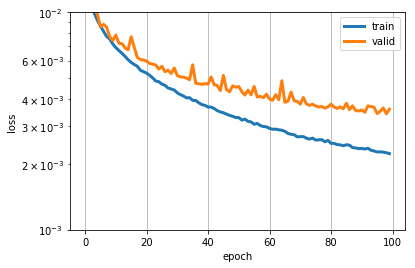

In [25]:
display_hist(hist1)

ImageId    1783
Image      1783
dtype: int64


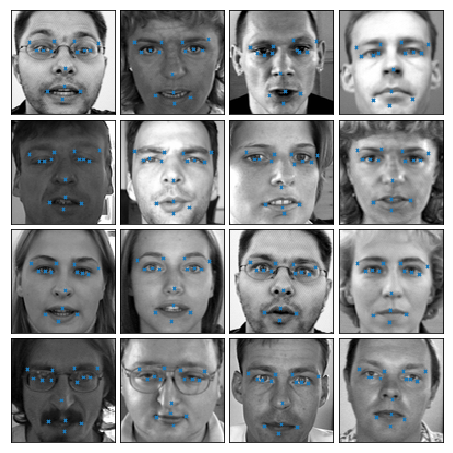

In [26]:
model_predict(model1)

In [27]:
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [33]:
hist2, model2 = model_fitting(net2(), 'model2')
model_save(model2, 'model2_architecture.json', 'model2_weights.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 1s - loss: 0.0326 - val_loss: 0.0070
Epoch 2/100
1712/1712 [==============================] - 1s - loss: 0.0068 - val_loss: 0.0061
Epoch 3/100
1712/1712 [==============================] - 1s - loss: 0.0060 - val_loss: 0.0055
Epoch 4/100
1712/1712 [==============================] - 1s - loss: 0.0055 - val_loss: 0.0052
Epoch 5/100
1712/1712 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0049
Epoch 6/100
1712/1712 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0048
Epoch 7/100
1712/1712 [==============================] - 1s - loss: 0.0047 - val_loss: 0.0046
Epoch 8/100
1712/1712 [==============================] - 1s - loss: 0.0046 - val_loss: 0.0045
Epoch 9/100
1712/1712 [==============================] - 1s - loss: 0.0045 - val_loss: 0.0044
Epoch 10/100
1712/1712 [==============================] - 1s - loss: 0.0045 - val_loss: 0.0044
Epoch 11/100

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


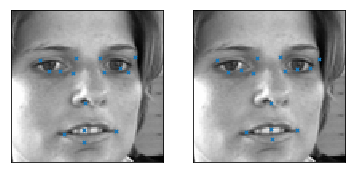

In [34]:
model_predict_comp(model1, model2)

In [35]:
X_flipped = Xflip()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

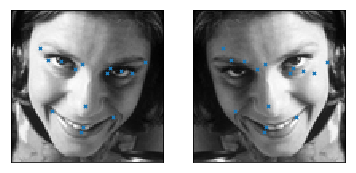

In [36]:
display_points()

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
hist3, model3 = model_fitting_gen(net2(), 'model3')
model_save(model3, 'model3_architecture.json', 'model3_weights.h5')

Epoch 1/100
1712/1712 [==============================] - 27s - loss: 0.0057 - val_loss: 0.0041
Epoch 2/100
1712/1712 [==============================] - 28s - loss: 0.0040 - val_loss: 0.0037
Epoch 3/100
1712/1712 [==============================] - 27s - loss: 0.0035 - val_loss: 0.0031
Epoch 4/100
1712/1712 [==============================] - 28s - loss: 0.0029 - val_loss: 0.0025
Epoch 5/100
1712/1712 [==============================] - 28s - loss: 0.0023 - val_loss: 0.0021
Epoch 6/100
1712/1712 [==============================] - 28s - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
1712/1712 [==============================] - 28s - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
1712/1712 [==============================] - 28s - loss: 0.0015 - val_loss: 0.0017
Epoch 9/100
1712/1712 [==============================] - 28s - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
1712/1712 [==============================] - 28s - loss: 0.0012 - val_loss: 0.0015
Epoch 11/100
1712/1712 [=========================

In [39]:
hist4, model4 = model_fitting_gen_cb(net2(), 'model4', nb_epoch=100)
model_save(model4, 'model4_architecture.json', 'model4_weights.h5')

Epoch 1/100
1712/1712 [==============================] - 28s - loss: 0.0044 - val_loss: 0.0028
Epoch 2/100
1712/1712 [==============================] - 28s - loss: 0.0021 - val_loss: 0.0018
Epoch 3/100
1712/1712 [==============================] - 28s - loss: 0.0014 - val_loss: 0.0015
Epoch 4/100
1712/1712 [==============================] - 28s - loss: 0.0011 - val_loss: 0.0014
Epoch 5/100
1712/1712 [==============================] - 28s - loss: 9.4301e-04 - val_loss: 0.0013
Epoch 6/100
1712/1712 [==============================] - 28s - loss: 8.1017e-04 - val_loss: 0.0012
Epoch 7/100
1712/1712 [==============================] - 28s - loss: 7.0824e-04 - val_loss: 0.0012
Epoch 8/100
1712/1712 [==============================] - 28s - loss: 6.2680e-04 - val_loss: 0.0012
Epoch 9/100
1712/1712 [==============================] - 28s - loss: 5.5980e-04 - val_loss: 0.0012
Epoch 10/100
1712/1712 [==============================] - 28s - loss: 5.0466e-04 - val_loss: 0.0011
Epoch 11/100
1712/1712 [=

1712/1712 [==============================] - 27s - loss: 4.9162e-05 - val_loss: 0.0012
Epoch 74/100
1712/1712 [==============================] - 28s - loss: 4.8578e-05 - val_loss: 0.0012
Epoch 75/100
1712/1712 [==============================] - 27s - loss: 4.8046e-05 - val_loss: 0.0012
Epoch 76/100
1712/1712 [==============================] - 27s - loss: 4.7570e-05 - val_loss: 0.0012
Epoch 77/100
1712/1712 [==============================] - 27s - loss: 4.7069e-05 - val_loss: 0.0012
Epoch 78/100
1712/1712 [==============================] - 28s - loss: 4.6602e-05 - val_loss: 0.0012
Epoch 79/100
1712/1712 [==============================] - 28s - loss: 4.6210e-05 - val_loss: 0.0012
Epoch 80/100
1712/1712 [==============================] - 27s - loss: 4.5720e-05 - val_loss: 0.0012
Epoch 81/100
1712/1712 [==============================] - 28s - loss: 4.5357e-05 - val_loss: 0.0012
Epoch 82/100
1712/1712 [==============================] - 27s - loss: 4.4985e-05 - val_loss: 0.0012
Epoch 83/100


In [40]:
hist5, model5 = model_fitting_gen_cb(net3(), 'model5', nb_epoch=100)
model_save(model5, 'model5_architecture.json', 'model5_weights.h5')
print('mean squared error', mean_squared_error(model5.predict(X), y))

Epoch 1/100
1712/1712 [==============================] - 31s - loss: 0.0055 - val_loss: 0.0040
Epoch 2/100
1712/1712 [==============================] - 31s - loss: 0.0039 - val_loss: 0.0033
Epoch 3/100
1712/1712 [==============================] - 30s - loss: 0.0032 - val_loss: 0.0025
Epoch 4/100
1712/1712 [==============================] - 30s - loss: 0.0026 - val_loss: 0.0021
Epoch 5/100
1712/1712 [==============================] - 30s - loss: 0.0023 - val_loss: 0.0019
Epoch 6/100
1712/1712 [==============================] - 31s - loss: 0.0021 - val_loss: 0.0018
Epoch 7/100
1712/1712 [==============================] - 31s - loss: 0.0020 - val_loss: 0.0016
Epoch 8/100
1712/1712 [==============================] - 31s - loss: 0.0019 - val_loss: 0.0016
Epoch 9/100
1712/1712 [==============================] - 30s - loss: 0.0018 - val_loss: 0.0015
Epoch 10/100
1712/1712 [==============================] - 31s - loss: 0.0017 - val_loss: 0.0014
Epoch 11/100
1712/1712 [=========================

1712/1712 [==============================] - 31s - loss: 9.2504e-04 - val_loss: 9.3203e-04
Epoch 60/100
1712/1712 [==============================] - 31s - loss: 9.2177e-04 - val_loss: 9.2801e-04
Epoch 61/100
1712/1712 [==============================] - 31s - loss: 9.1974e-04 - val_loss: 9.3357e-04
Epoch 62/100
1712/1712 [==============================] - 31s - loss: 9.1454e-04 - val_loss: 9.2560e-04
Epoch 63/100
1712/1712 [==============================] - 31s - loss: 9.1049e-04 - val_loss: 9.2339e-04
Epoch 64/100
1712/1712 [==============================] - 30s - loss: 9.0846e-04 - val_loss: 9.2334e-04
Epoch 65/100
1712/1712 [==============================] - 30s - loss: 9.0571e-04 - val_loss: 9.2633e-04
Epoch 66/100
1712/1712 [==============================] - 30s - loss: 9.0110e-04 - val_loss: 9.1751e-04
Epoch 67/100
1712/1712 [==============================] - 30s - loss: 8.9979e-04 - val_loss: 9.1276e-04
Epoch 68/100
1712/1712 [==============================] - 30s - loss: 8.9810e

In [41]:
hist6, model6 = model_fitting_gen_cb(net4(), 'model6', nb_epoch=100)
model_save(model6, 'model6_architecture.json', 'model6_weights.h5')

Epoch 1/100
1712/1712 [==============================] - 36s - loss: 0.0054 - val_loss: 0.0044
Epoch 2/100
1712/1712 [==============================] - 36s - loss: 0.0040 - val_loss: 0.0035
Epoch 3/100
1712/1712 [==============================] - 36s - loss: 0.0032 - val_loss: 0.0026
Epoch 4/100
1712/1712 [==============================] - 36s - loss: 0.0026 - val_loss: 0.0021
Epoch 5/100
1712/1712 [==============================] - 36s - loss: 0.0022 - val_loss: 0.0019
Epoch 6/100
1712/1712 [==============================] - 36s - loss: 0.0020 - val_loss: 0.0017
Epoch 7/100
1712/1712 [==============================] - 36s - loss: 0.0019 - val_loss: 0.0016
Epoch 8/100
1712/1712 [==============================] - 36s - loss: 0.0018 - val_loss: 0.0015
Epoch 9/100
1712/1712 [==============================] - 36s - loss: 0.0017 - val_loss: 0.0015
Epoch 10/100
1712/1712 [==============================] - 36s - loss: 0.0016 - val_loss: 0.0014
Epoch 11/100
1712/1712 [=========================

1712/1712 [==============================] - 36s - loss: 8.1242e-04 - val_loss: 9.1048e-04
Epoch 59/100
1712/1712 [==============================] - 36s - loss: 8.1202e-04 - val_loss: 9.0831e-04
Epoch 60/100
1712/1712 [==============================] - 36s - loss: 8.0976e-04 - val_loss: 9.0718e-04
Epoch 61/100
1712/1712 [==============================] - 36s - loss: 8.0595e-04 - val_loss: 8.9934e-04
Epoch 62/100
1712/1712 [==============================] - 36s - loss: 8.0006e-04 - val_loss: 9.0361e-04
Epoch 63/100
1712/1712 [==============================] - 36s - loss: 7.9917e-04 - val_loss: 9.0237e-04
Epoch 64/100
1712/1712 [==============================] - 36s - loss: 7.9280e-04 - val_loss: 9.0187e-04
Epoch 65/100
1712/1712 [==============================] - 36s - loss: 7.9190e-04 - val_loss: 8.9412e-04
Epoch 66/100
1712/1712 [==============================] - 36s - loss: 7.8845e-04 - val_loss: 8.9657e-04
Epoch 67/100
1712/1712 [==============================] - 36s - loss: 7.8647e

モデル2のファインチューニング
追加学習2000epoch

In [28]:
model2 = model_from_json(open('model2_architecture.json').read())
model2.load_weights('model2_weights.h5')
hist2_p2000, model2_p2000 = model_fitting(model2, 'model2_p2000', 2000)
model_save(model2_p2000, 'model2_p2000_architecture.json', 'model2_p2000_weights.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/2000
1712/1712 [==============================] - 1s - loss: 0.0025 - val_loss: 0.0026
Epoch 2/2000
1712/1712 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0026
Epoch 3/2000
1712/1712 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0026
Epoch 4/2000
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0025
Epoch 5/2000
1712/1712 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0025
Epoch 6/2000
1712/1712 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0025
Epoch 7/2000
1712/1712 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0025
Epoch 8/2000
1712/1712 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0024
Epoch 9/2000
1712/1712 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0024
Epoch 10/2000
1712/1712 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0024
Ep

1712/1712 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 86/2000
1712/1712 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 87/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 88/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 89/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 90/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 91/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 92/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 93/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 94/2000
1712/1712 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 95/2000
1712/1712 [=============================

1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 170/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 171/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 172/2000
1712/1712 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0016
Epoch 173/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 174/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 175/2000
1712/1712 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0016
Epoch 176/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 177/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 178/2000
1712/1712 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 179/2000
1712/1712 [===================

1712/1712 [==============================] - 1s - loss: 9.8911e-04 - val_loss: 0.0015
Epoch 254/2000
1712/1712 [==============================] - 1s - loss: 9.8743e-04 - val_loss: 0.0015
Epoch 255/2000
1712/1712 [==============================] - 1s - loss: 9.8632e-04 - val_loss: 0.0015
Epoch 256/2000
1712/1712 [==============================] - 1s - loss: 9.8222e-04 - val_loss: 0.0015
Epoch 257/2000
1712/1712 [==============================] - 1s - loss: 9.8230e-04 - val_loss: 0.0015
Epoch 258/2000
1712/1712 [==============================] - 1s - loss: 9.7987e-04 - val_loss: 0.0015
Epoch 259/2000
1712/1712 [==============================] - 1s - loss: 9.7667e-04 - val_loss: 0.0015
Epoch 260/2000
1712/1712 [==============================] - 0s - loss: 9.7537e-04 - val_loss: 0.0015
Epoch 261/2000
1712/1712 [==============================] - 1s - loss: 9.7224e-04 - val_loss: 0.0015
Epoch 262/2000
1712/1712 [==============================] - 0s - loss: 9.7072e-04 - val_loss: 0.0015
Epoch

1712/1712 [==============================] - 0s - loss: 8.4950e-04 - val_loss: 0.0014
Epoch 335/2000
1712/1712 [==============================] - 1s - loss: 8.4914e-04 - val_loss: 0.0015
Epoch 336/2000
1712/1712 [==============================] - 1s - loss: 8.4751e-04 - val_loss: 0.0014
Epoch 337/2000
1712/1712 [==============================] - 1s - loss: 8.4581e-04 - val_loss: 0.0014
Epoch 338/2000
1712/1712 [==============================] - 0s - loss: 8.4526e-04 - val_loss: 0.0014
Epoch 339/2000
1712/1712 [==============================] - 0s - loss: 8.4187e-04 - val_loss: 0.0015
Epoch 340/2000
1712/1712 [==============================] - 0s - loss: 8.4339e-04 - val_loss: 0.0014
Epoch 341/2000
1712/1712 [==============================] - 1s - loss: 8.3874e-04 - val_loss: 0.0014
Epoch 342/2000
1712/1712 [==============================] - 0s - loss: 8.3802e-04 - val_loss: 0.0014
Epoch 343/2000
1712/1712 [==============================] - 0s - loss: 8.3649e-04 - val_loss: 0.0015
Epoch

1712/1712 [==============================] - 1s - loss: 7.4381e-04 - val_loss: 0.0014
Epoch 416/2000
1712/1712 [==============================] - 0s - loss: 7.4216e-04 - val_loss: 0.0014
Epoch 417/2000
1712/1712 [==============================] - 0s - loss: 7.3934e-04 - val_loss: 0.0014
Epoch 418/2000
1712/1712 [==============================] - 1s - loss: 7.3908e-04 - val_loss: 0.0014
Epoch 419/2000
1712/1712 [==============================] - 0s - loss: 7.3463e-04 - val_loss: 0.0014
Epoch 420/2000
1712/1712 [==============================] - 0s - loss: 7.3507e-04 - val_loss: 0.0014
Epoch 421/2000
1712/1712 [==============================] - 0s - loss: 7.3346e-04 - val_loss: 0.0014
Epoch 422/2000
1712/1712 [==============================] - 0s - loss: 7.3400e-04 - val_loss: 0.0014
Epoch 423/2000
1712/1712 [==============================] - 0s - loss: 7.3228e-04 - val_loss: 0.0014
Epoch 424/2000
1712/1712 [==============================] - 1s - loss: 7.3341e-04 - val_loss: 0.0014
Epoch

1712/1712 [==============================] - 0s - loss: 6.5379e-04 - val_loss: 0.0014
Epoch 497/2000
1712/1712 [==============================] - 1s - loss: 6.5411e-04 - val_loss: 0.0014
Epoch 498/2000
1712/1712 [==============================] - 1s - loss: 6.5220e-04 - val_loss: 0.0014
Epoch 499/2000
1712/1712 [==============================] - 1s - loss: 6.5016e-04 - val_loss: 0.0014
Epoch 500/2000
1712/1712 [==============================] - 0s - loss: 6.5002e-04 - val_loss: 0.0014
Epoch 501/2000
1712/1712 [==============================] - 1s - loss: 6.4896e-04 - val_loss: 0.0014
Epoch 502/2000
1712/1712 [==============================] - 0s - loss: 6.4759e-04 - val_loss: 0.0014
Epoch 503/2000
1712/1712 [==============================] - 0s - loss: 6.4857e-04 - val_loss: 0.0014
Epoch 504/2000
1712/1712 [==============================] - 0s - loss: 6.4736e-04 - val_loss: 0.0014
Epoch 505/2000
1712/1712 [==============================] - 0s - loss: 6.4409e-04 - val_loss: 0.0014
Epoch

1712/1712 [==============================] - 1s - loss: 5.7960e-04 - val_loss: 0.0013
Epoch 578/2000
1712/1712 [==============================] - 0s - loss: 5.7888e-04 - val_loss: 0.0013
Epoch 579/2000
1712/1712 [==============================] - 1s - loss: 5.7702e-04 - val_loss: 0.0014
Epoch 580/2000
1712/1712 [==============================] - 1s - loss: 5.7738e-04 - val_loss: 0.0013
Epoch 581/2000
1712/1712 [==============================] - 0s - loss: 5.7600e-04 - val_loss: 0.0013
Epoch 582/2000
1712/1712 [==============================] - 1s - loss: 5.7535e-04 - val_loss: 0.0013
Epoch 583/2000
1712/1712 [==============================] - 0s - loss: 5.7454e-04 - val_loss: 0.0013
Epoch 584/2000
1712/1712 [==============================] - 1s - loss: 5.7240e-04 - val_loss: 0.0013
Epoch 585/2000
1712/1712 [==============================] - 1s - loss: 5.7247e-04 - val_loss: 0.0014
Epoch 586/2000
1712/1712 [==============================] - 0s - loss: 5.7141e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 1s - loss: 5.1770e-04 - val_loss: 0.0013
Epoch 659/2000
1712/1712 [==============================] - 0s - loss: 5.1645e-04 - val_loss: 0.0013
Epoch 660/2000
1712/1712 [==============================] - 0s - loss: 5.1689e-04 - val_loss: 0.0013
Epoch 661/2000
1712/1712 [==============================] - 0s - loss: 5.1478e-04 - val_loss: 0.0013
Epoch 662/2000
1712/1712 [==============================] - 0s - loss: 5.1450e-04 - val_loss: 0.0013
Epoch 663/2000
1712/1712 [==============================] - 0s - loss: 5.1469e-04 - val_loss: 0.0013
Epoch 664/2000
1712/1712 [==============================] - 0s - loss: 5.1312e-04 - val_loss: 0.0013
Epoch 665/2000
1712/1712 [==============================] - 1s - loss: 5.1217e-04 - val_loss: 0.0013
Epoch 666/2000
1712/1712 [==============================] - 0s - loss: 5.1326e-04 - val_loss: 0.0013
Epoch 667/2000
1712/1712 [==============================] - 1s - loss: 5.1168e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 0s - loss: 4.6524e-04 - val_loss: 0.0013
Epoch 740/2000
1712/1712 [==============================] - 1s - loss: 4.6556e-04 - val_loss: 0.0013
Epoch 741/2000
1712/1712 [==============================] - 1s - loss: 4.6378e-04 - val_loss: 0.0013
Epoch 742/2000
1712/1712 [==============================] - 1s - loss: 4.6450e-04 - val_loss: 0.0013
Epoch 743/2000
1712/1712 [==============================] - 1s - loss: 4.6394e-04 - val_loss: 0.0013
Epoch 744/2000
1712/1712 [==============================] - 1s - loss: 4.6261e-04 - val_loss: 0.0013
Epoch 745/2000
1712/1712 [==============================] - 1s - loss: 4.6179e-04 - val_loss: 0.0013
Epoch 746/2000
1712/1712 [==============================] - 1s - loss: 4.6110e-04 - val_loss: 0.0013
Epoch 747/2000
1712/1712 [==============================] - 1s - loss: 4.6043e-04 - val_loss: 0.0013
Epoch 748/2000
1712/1712 [==============================] - 0s - loss: 4.5955e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 1s - loss: 4.2136e-04 - val_loss: 0.0013
Epoch 821/2000
1712/1712 [==============================] - 0s - loss: 4.2108e-04 - val_loss: 0.0013
Epoch 822/2000
1712/1712 [==============================] - 0s - loss: 4.1977e-04 - val_loss: 0.0013
Epoch 823/2000
1712/1712 [==============================] - 1s - loss: 4.2049e-04 - val_loss: 0.0013
Epoch 824/2000
1712/1712 [==============================] - 0s - loss: 4.1897e-04 - val_loss: 0.0013
Epoch 825/2000
1712/1712 [==============================] - 0s - loss: 4.1771e-04 - val_loss: 0.0013
Epoch 826/2000
1712/1712 [==============================] - 0s - loss: 4.1928e-04 - val_loss: 0.0013
Epoch 827/2000
1712/1712 [==============================] - 1s - loss: 4.1779e-04 - val_loss: 0.0013
Epoch 828/2000
1712/1712 [==============================] - 1s - loss: 4.1712e-04 - val_loss: 0.0013
Epoch 829/2000
1712/1712 [==============================] - 0s - loss: 4.1666e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 1s - loss: 3.8265e-04 - val_loss: 0.0013
Epoch 902/2000
1712/1712 [==============================] - 1s - loss: 3.8307e-04 - val_loss: 0.0013
Epoch 903/2000
1712/1712 [==============================] - 0s - loss: 3.8235e-04 - val_loss: 0.0013
Epoch 904/2000
1712/1712 [==============================] - 0s - loss: 3.8272e-04 - val_loss: 0.0013
Epoch 905/2000
1712/1712 [==============================] - 0s - loss: 3.8180e-04 - val_loss: 0.0013
Epoch 906/2000
1712/1712 [==============================] - 1s - loss: 3.8133e-04 - val_loss: 0.0013
Epoch 907/2000
1712/1712 [==============================] - 1s - loss: 3.8074e-04 - val_loss: 0.0013
Epoch 908/2000
1712/1712 [==============================] - 0s - loss: 3.7997e-04 - val_loss: 0.0013
Epoch 909/2000
1712/1712 [==============================] - 1s - loss: 3.7925e-04 - val_loss: 0.0013
Epoch 910/2000
1712/1712 [==============================] - 1s - loss: 3.7863e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 0s - loss: 3.5022e-04 - val_loss: 0.0013
Epoch 983/2000
1712/1712 [==============================] - 1s - loss: 3.4902e-04 - val_loss: 0.0013
Epoch 984/2000
1712/1712 [==============================] - 1s - loss: 3.4879e-04 - val_loss: 0.0013
Epoch 985/2000
1712/1712 [==============================] - 1s - loss: 3.4968e-04 - val_loss: 0.0013
Epoch 986/2000
1712/1712 [==============================] - 1s - loss: 3.4867e-04 - val_loss: 0.0013
Epoch 987/2000
1712/1712 [==============================] - 0s - loss: 3.4736e-04 - val_loss: 0.0013
Epoch 988/2000
1712/1712 [==============================] - 1s - loss: 3.4772e-04 - val_loss: 0.0013
Epoch 989/2000
1712/1712 [==============================] - 0s - loss: 3.4816e-04 - val_loss: 0.0013
Epoch 990/2000
1712/1712 [==============================] - 1s - loss: 3.4757e-04 - val_loss: 0.0013
Epoch 991/2000
1712/1712 [==============================] - 0s - loss: 3.4614e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 1s - loss: 3.2162e-04 - val_loss: 0.0013
Epoch 1063/2000
1712/1712 [==============================] - 1s - loss: 3.2203e-04 - val_loss: 0.0013
Epoch 1064/2000
1712/1712 [==============================] - 1s - loss: 3.2130e-04 - val_loss: 0.0013
Epoch 1065/2000
1712/1712 [==============================] - 1s - loss: 3.2089e-04 - val_loss: 0.0013
Epoch 1066/2000
1712/1712 [==============================] - 1s - loss: 3.2048e-04 - val_loss: 0.0013
Epoch 1067/2000
1712/1712 [==============================] - 1s - loss: 3.2018e-04 - val_loss: 0.0013
Epoch 1068/2000
1712/1712 [==============================] - 1s - loss: 3.1968e-04 - val_loss: 0.0013
Epoch 1069/2000
1712/1712 [==============================] - 1s - loss: 3.1929e-04 - val_loss: 0.0013
Epoch 1070/2000
1712/1712 [==============================] - 1s - loss: 3.1932e-04 - val_loss: 0.0013
Epoch 1071/2000
1712/1712 [==============================] - 1s - loss: 3.1869e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 2.9694e-04 - val_loss: 0.0013
Epoch 1143/2000
1712/1712 [==============================] - 1s - loss: 2.9629e-04 - val_loss: 0.0013
Epoch 1144/2000
1712/1712 [==============================] - 1s - loss: 2.9661e-04 - val_loss: 0.0013
Epoch 1145/2000
1712/1712 [==============================] - 0s - loss: 2.9594e-04 - val_loss: 0.0013
Epoch 1146/2000
1712/1712 [==============================] - 1s - loss: 2.9542e-04 - val_loss: 0.0013
Epoch 1147/2000
1712/1712 [==============================] - 0s - loss: 2.9452e-04 - val_loss: 0.0013
Epoch 1148/2000
1712/1712 [==============================] - 0s - loss: 2.9497e-04 - val_loss: 0.0013
Epoch 1149/2000
1712/1712 [==============================] - 1s - loss: 2.9402e-04 - val_loss: 0.0013
Epoch 1150/2000
1712/1712 [==============================] - 1s - loss: 2.9434e-04 - val_loss: 0.0013
Epoch 1151/2000
1712/1712 [==============================] - 0s - loss: 2.9442e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 2.7411e-04 - val_loss: 0.0013
Epoch 1223/2000
1712/1712 [==============================] - 1s - loss: 2.7474e-04 - val_loss: 0.0013
Epoch 1224/2000
1712/1712 [==============================] - 0s - loss: 2.7375e-04 - val_loss: 0.0013
Epoch 1225/2000
1712/1712 [==============================] - 0s - loss: 2.7385e-04 - val_loss: 0.0013
Epoch 1226/2000
1712/1712 [==============================] - 1s - loss: 2.7440e-04 - val_loss: 0.0013
Epoch 1227/2000
1712/1712 [==============================] - 0s - loss: 2.7421e-04 - val_loss: 0.0013
Epoch 1228/2000
1712/1712 [==============================] - 1s - loss: 2.7325e-04 - val_loss: 0.0013
Epoch 1229/2000
1712/1712 [==============================] - 0s - loss: 2.7333e-04 - val_loss: 0.0013
Epoch 1230/2000
1712/1712 [==============================] - 0s - loss: 2.7242e-04 - val_loss: 0.0013
Epoch 1231/2000
1712/1712 [==============================] - 0s - loss: 2.7234e-04 - val_loss: 0.0

1712/1712 [==============================] - 0s - loss: 2.5566e-04 - val_loss: 0.0013
Epoch 1303/2000
1712/1712 [==============================] - 0s - loss: 2.5451e-04 - val_loss: 0.0013
Epoch 1304/2000
1712/1712 [==============================] - 0s - loss: 2.5399e-04 - val_loss: 0.0013
Epoch 1305/2000
1712/1712 [==============================] - 0s - loss: 2.5409e-04 - val_loss: 0.0013
Epoch 1306/2000
1712/1712 [==============================] - 0s - loss: 2.5410e-04 - val_loss: 0.0013
Epoch 1307/2000
1712/1712 [==============================] - 1s - loss: 2.5359e-04 - val_loss: 0.0013
Epoch 1308/2000
1712/1712 [==============================] - 1s - loss: 2.5378e-04 - val_loss: 0.0013
Epoch 1309/2000
1712/1712 [==============================] - 0s - loss: 2.5321e-04 - val_loss: 0.0013
Epoch 1310/2000
1712/1712 [==============================] - 0s - loss: 2.5359e-04 - val_loss: 0.0013
Epoch 1311/2000
1712/1712 [==============================] - 1s - loss: 2.5336e-04 - val_loss: 0.0

1712/1712 [==============================] - 0s - loss: 2.3718e-04 - val_loss: 0.0013
Epoch 1383/2000
1712/1712 [==============================] - 0s - loss: 2.3681e-04 - val_loss: 0.0013
Epoch 1384/2000
1712/1712 [==============================] - 1s - loss: 2.3760e-04 - val_loss: 0.0013
Epoch 1385/2000
1712/1712 [==============================] - 1s - loss: 2.3764e-04 - val_loss: 0.0013
Epoch 1386/2000
1712/1712 [==============================] - 0s - loss: 2.3608e-04 - val_loss: 0.0013
Epoch 1387/2000
1712/1712 [==============================] - 1s - loss: 2.3691e-04 - val_loss: 0.0013
Epoch 1388/2000
1712/1712 [==============================] - 0s - loss: 2.3602e-04 - val_loss: 0.0013
Epoch 1389/2000
1712/1712 [==============================] - 1s - loss: 2.3606e-04 - val_loss: 0.0013
Epoch 1390/2000
1712/1712 [==============================] - 1s - loss: 2.3541e-04 - val_loss: 0.0013
Epoch 1391/2000
1712/1712 [==============================] - 1s - loss: 2.3552e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 2.2158e-04 - val_loss: 0.0013
Epoch 1463/2000
1712/1712 [==============================] - 1s - loss: 2.2244e-04 - val_loss: 0.0013
Epoch 1464/2000
1712/1712 [==============================] - 1s - loss: 2.2132e-04 - val_loss: 0.0013
Epoch 1465/2000
1712/1712 [==============================] - 1s - loss: 2.2131e-04 - val_loss: 0.0013
Epoch 1466/2000
1712/1712 [==============================] - 1s - loss: 2.2108e-04 - val_loss: 0.0013
Epoch 1467/2000
1712/1712 [==============================] - 0s - loss: 2.2111e-04 - val_loss: 0.0013
Epoch 1468/2000
1712/1712 [==============================] - 0s - loss: 2.2093e-04 - val_loss: 0.0013
Epoch 1469/2000
1712/1712 [==============================] - 1s - loss: 2.2067e-04 - val_loss: 0.0013
Epoch 1470/2000
1712/1712 [==============================] - 0s - loss: 2.1994e-04 - val_loss: 0.0013
Epoch 1471/2000
1712/1712 [==============================] - 1s - loss: 2.2032e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 2.0731e-04 - val_loss: 0.0013
Epoch 1543/2000
1712/1712 [==============================] - 0s - loss: 2.0749e-04 - val_loss: 0.0013
Epoch 1544/2000
1712/1712 [==============================] - 0s - loss: 2.0798e-04 - val_loss: 0.0013
Epoch 1545/2000
1712/1712 [==============================] - 0s - loss: 2.0737e-04 - val_loss: 0.0013
Epoch 1546/2000
1712/1712 [==============================] - 1s - loss: 2.0737e-04 - val_loss: 0.0013
Epoch 1547/2000
1712/1712 [==============================] - 1s - loss: 2.0682e-04 - val_loss: 0.0013
Epoch 1548/2000
1712/1712 [==============================] - 0s - loss: 2.0643e-04 - val_loss: 0.0013
Epoch 1549/2000
1712/1712 [==============================] - 1s - loss: 2.0703e-04 - val_loss: 0.0013
Epoch 1550/2000
1712/1712 [==============================] - 1s - loss: 2.0646e-04 - val_loss: 0.0013
Epoch 1551/2000
1712/1712 [==============================] - 0s - loss: 2.0560e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 1.9529e-04 - val_loss: 0.0013
Epoch 1623/2000
1712/1712 [==============================] - 0s - loss: 1.9468e-04 - val_loss: 0.0013
Epoch 1624/2000
1712/1712 [==============================] - 0s - loss: 1.9476e-04 - val_loss: 0.0013
Epoch 1625/2000
1712/1712 [==============================] - 1s - loss: 1.9455e-04 - val_loss: 0.0013
Epoch 1626/2000
1712/1712 [==============================] - 1s - loss: 1.9497e-04 - val_loss: 0.0013
Epoch 1627/2000
1712/1712 [==============================] - 1s - loss: 1.9421e-04 - val_loss: 0.0013
Epoch 1628/2000
1712/1712 [==============================] - 0s - loss: 1.9415e-04 - val_loss: 0.0013
Epoch 1629/2000
1712/1712 [==============================] - 1s - loss: 1.9392e-04 - val_loss: 0.0013
Epoch 1630/2000
1712/1712 [==============================] - 1s - loss: 1.9322e-04 - val_loss: 0.0013
Epoch 1631/2000
1712/1712 [==============================] - 1s - loss: 1.9339e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 1.8325e-04 - val_loss: 0.0013
Epoch 1703/2000
1712/1712 [==============================] - 1s - loss: 1.8313e-04 - val_loss: 0.0013
Epoch 1704/2000
1712/1712 [==============================] - 0s - loss: 1.8323e-04 - val_loss: 0.0013
Epoch 1705/2000
1712/1712 [==============================] - 0s - loss: 1.8252e-04 - val_loss: 0.0013
Epoch 1706/2000
1712/1712 [==============================] - 1s - loss: 1.8273e-04 - val_loss: 0.0013
Epoch 1707/2000
1712/1712 [==============================] - 0s - loss: 1.8233e-04 - val_loss: 0.0013
Epoch 1708/2000
1712/1712 [==============================] - 0s - loss: 1.8285e-04 - val_loss: 0.0013
Epoch 1709/2000
1712/1712 [==============================] - 1s - loss: 1.8203e-04 - val_loss: 0.0013
Epoch 1710/2000
1712/1712 [==============================] - 0s - loss: 1.8253e-04 - val_loss: 0.0013
Epoch 1711/2000
1712/1712 [==============================] - 0s - loss: 1.8218e-04 - val_loss: 0.0

1712/1712 [==============================] - 1s - loss: 1.7282e-04 - val_loss: 0.0013
Epoch 1783/2000
1712/1712 [==============================] - 1s - loss: 1.7275e-04 - val_loss: 0.0013
Epoch 1784/2000
1712/1712 [==============================] - 0s - loss: 1.7285e-04 - val_loss: 0.0013
Epoch 1785/2000
1712/1712 [==============================] - 1s - loss: 1.7220e-04 - val_loss: 0.0013
Epoch 1786/2000
1712/1712 [==============================] - 0s - loss: 1.7241e-04 - val_loss: 0.0013
Epoch 1787/2000
1712/1712 [==============================] - 1s - loss: 1.7242e-04 - val_loss: 0.0013
Epoch 1788/2000
1712/1712 [==============================] - 1s - loss: 1.7184e-04 - val_loss: 0.0013
Epoch 1789/2000
1712/1712 [==============================] - 1s - loss: 1.7158e-04 - val_loss: 0.0013
Epoch 1790/2000
1712/1712 [==============================] - 1s - loss: 1.7199e-04 - val_loss: 0.0013
Epoch 1791/2000
1712/1712 [==============================] - 1s - loss: 1.7164e-04 - val_loss: 0.0

1712/1712 [==============================] - 0s - loss: 1.6309e-04 - val_loss: 0.0013
Epoch 1863/2000
1712/1712 [==============================] - 1s - loss: 1.6259e-04 - val_loss: 0.0013
Epoch 1864/2000
1712/1712 [==============================] - 1s - loss: 1.6279e-04 - val_loss: 0.0013
Epoch 1865/2000
1712/1712 [==============================] - 0s - loss: 1.6261e-04 - val_loss: 0.0013
Epoch 1866/2000
1712/1712 [==============================] - 0s - loss: 1.6262e-04 - val_loss: 0.0013
Epoch 1867/2000
1712/1712 [==============================] - 1s - loss: 1.6232e-04 - val_loss: 0.0013
Epoch 1868/2000
1712/1712 [==============================] - 0s - loss: 1.6210e-04 - val_loss: 0.0013
Epoch 1869/2000
1712/1712 [==============================] - 0s - loss: 1.6218e-04 - val_loss: 0.0013
Epoch 1870/2000
1712/1712 [==============================] - 1s - loss: 1.6202e-04 - val_loss: 0.0013
Epoch 1871/2000
1712/1712 [==============================] - 1s - loss: 1.6187e-04 - val_loss: 0.0

1712/1712 [==============================] - 0s - loss: 1.5412e-04 - val_loss: 0.0013
Epoch 1943/2000
1712/1712 [==============================] - 1s - loss: 1.5420e-04 - val_loss: 0.0014
Epoch 1944/2000
1712/1712 [==============================] - 0s - loss: 1.5392e-04 - val_loss: 0.0013
Epoch 1945/2000
1712/1712 [==============================] - 0s - loss: 1.5409e-04 - val_loss: 0.0013
Epoch 1946/2000
1712/1712 [==============================] - 0s - loss: 1.5357e-04 - val_loss: 0.0013
Epoch 1947/2000
1712/1712 [==============================] - 0s - loss: 1.5342e-04 - val_loss: 0.0013
Epoch 1948/2000
1712/1712 [==============================] - 0s - loss: 1.5383e-04 - val_loss: 0.0013
Epoch 1949/2000
1712/1712 [==============================] - 1s - loss: 1.5327e-04 - val_loss: 0.0014
Epoch 1950/2000
1712/1712 [==============================] - 0s - loss: 1.5292e-04 - val_loss: 0.0013
Epoch 1951/2000
1712/1712 [==============================] - 0s - loss: 1.5320e-04 - val_loss: 0.0

読み込み2つのモデル

In [36]:
model2 = model_from_json(open('model2_architecture.json').read())
model2.load_weights('model2_weights.h5')
model2_p2000 = model_from_json(open('model2_p2000_architecture.json').read())
model2_p2000.load_weights('model2_p2000_weights.h5')

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


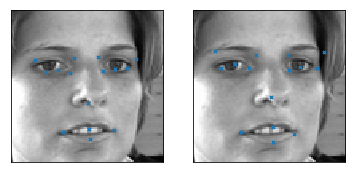

In [38]:
model_predict_comp2d(model2, model2_p2000)

読み込み2つのモデル

In [34]:
model4 = model_from_json(open('model4_architecture.json').read())
model4.load_weights('model4_weights.h5')
model6 = model_from_json(open('model6_architecture.json').read())
model6.load_weights('model6_weights.h5')

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


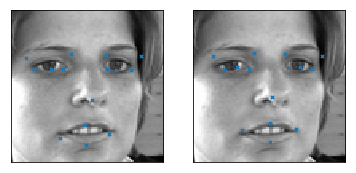

In [39]:
model_predict_comp2d(model4, model6)